In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms

# 防止内核挂掉
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Angular Spectrum Propagation (phase & amplitude)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device: ',device)

Using Device:  cuda


### ***Loading and Viewing Dataset***

batch_number [100/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


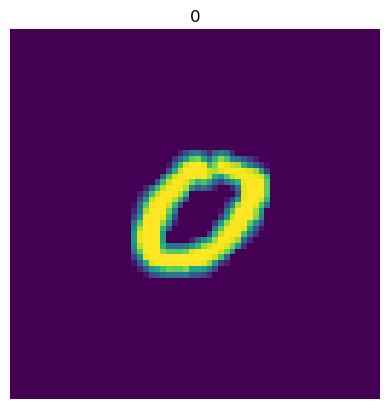

batch_number [200/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


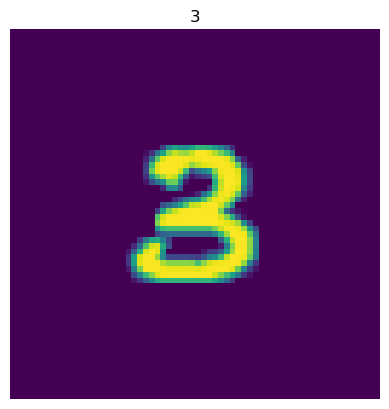

batch_number [300/300]
classes of the first batch: [0 1 2 3 4 5 6 7 8 9], number of classes: 10


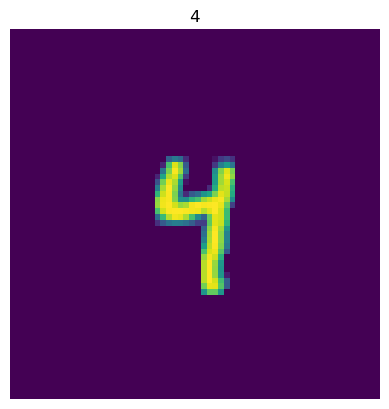

In [112]:
BATCH_SIZE = 200
IMG_SIZE = 32
N_pixels = 64
PADDING = (N_pixels - IMG_SIZE) // 2  # 避免边缘信息丢失

# 数据预处理并加载
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.Pad([PADDING, PADDING], fill=(0), padding_mode='constant'),
#                                 transforms.Normalize((0.1307,), (0.3081,))
                               ]
                               )
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定义一个绘图函数
def image_plot(image, label):
#     cmap='RdBu'
    fig, ax = plt.subplots()
    ax.imshow(np.round(image.cpu().numpy(), 5)) # 显示图片每个像素点的振幅
    ax.axis('off')
    ax.set_title(label.cpu().numpy())
#     fig.colorbar(plt.cm.ScalarMappable(cmap=cmap))
    plt.show()

for i, (images, labels) in enumerate(train_dataloader):
    images = images.to(device)
#     images_E = torch.sqrt((torch.squeeze(images)+1)/2)
    images_E = torch.sqrt(torch.squeeze(images))
    labels = labels.to(device)

    '''
        每一个周期，共300个批次（i=0~299），一共60000个数据；
        train_dataloader包含300个批次，包括整个训练集；
        每一批次一共200张图片，对应200个标签, len(images[0])=1；
        images包含一个批次的200张图片（image[0].shape=torch.Size([1,28,28])），labels包含一个批次的200个标签，标签范围为0~9
    '''

    #每100个批次绘制第一张图片（含shuffle导致每次运行结果不一样）
    if (i + 1) % 100 == 0:
        classes = torch.unique(labels).cpu().numpy()
        classes_num = len(classes)
        print('batch_number [{}/{}]'.format(i + 1, len(train_dataloader)))
        print('classes of the first batch: {}, number of classes: {}'.format(classes, classes_num))#  第一个batch的总类
#         image_plot(images_phase[0], labels[0])
        image_plot(images_E[0], labels[0])


In [113]:
images_E.shape

torch.Size([200, 64, 64])

### ***Diffractive Layer***

In [114]:
class Diffractive_Layer(torch.nn.Module):
    # 模型初始化（构造实例），默认实参波长为532e-9，网格总数50，网格大小20e-6，z方向传播0.002。
    def __init__(self, λ = 532e-9, N_pixels = 64, pixel_size = 20e-6, distance = torch.tensor([0.02])):
        super(Diffractive_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

torch.Size([200, 64, 64])

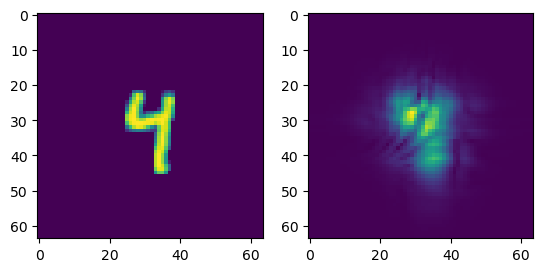

In [115]:
# 看看一个样本经过衍射层后变成啥样
model = Diffractive_Layer().to(device)
out = model(images_E)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images_E[0].squeeze().cpu())
ax2.imshow(torch.abs(out[0]).cpu())
out.shape

In [116]:
# 原图像总光强
torch.pow(abs(images_E[0]), 2).sum()

tensor(107.1872, device='cuda:0')

In [117]:
# 输出图像总光强
torch.pow(abs(out[0]), 2).sum()

tensor(107.1872, device='cuda:0', dtype=torch.float64)

### ***Propagation Layer***

In [118]:
class Propagation_Layer(torch.nn.Module):
    # 与上面衍射层大致相同，区别在于传输层是最后一个衍射层到探测器层间的部分，中间可以自定义加额外的器件。
    def __init__(self, λ = 532e-9, N_pixels = 64, pixel_size = 20e-6, distance = torch.tensor([0.001])):
        super(Propagation_Layer, self).__init__() # 初始化父类
        
        # 以1/d为单位频率，得到一系列频率分量[0, 1, 2, ···, N_pixels/2-1,-N_pixels/2, ···, -1]/(N_pixels*d)。
        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy) # 拉网格，每个网格坐标点为空间频率各分量。

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        # 计算传播场或倏逝场的模式kz，传播场kz为实数，倏逝场kz为复数
        tmp = np.sqrt(np.abs(argument))
        self.distance = distance.to(device)
        self.kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp)).to(device)

    def forward(self, E):
        # 定义单个衍射层内的前向传播
        fft_c = torch.fft.fft2(E) # 对电场E进行二维傅里叶变换
        c = torch.fft.fftshift(fft_c) # 将零频移至张量中心
        phase = torch.exp(1j * self.kz * self.distance).to(device)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * phase)) # 卷积后逆变换得到响应的角谱
        return angular_spectrum

### ***Detectors Layer***

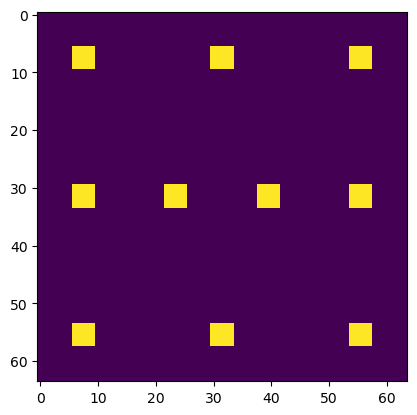

In [119]:
# 生成一行探测器。指定探测器个数N_det，在x方向上生成齐高等间距det_step的一组探测器
# left，right，up和down分别是该行矩形探测器的四个顶点坐标。
def generate_det_row(det_size, start_pos_x, start_pos_y, det_step, N_det):
    p = []
    for i in range(N_det):
        left = start_pos_x+i*(int(det_step)+det_size)
        right = left + det_size
        up = start_pos_y
        down = start_pos_y + det_size
        p.append((up, down, left, right))
    return p

# 生成三行探测器。利用generate_det_row函数生成三行等间距矩形探测器。
def set_det_pos(det_size = 20, start_pos_x = 46, start_pos_y = 46, 
                N_det_sets = [3, 4, 3], det_steps_x = [5, 3, 5], det_steps_y = 5):
    p = []
    for i in range(len(N_det_sets)):
        p.append(generate_det_row(det_size, start_pos_x, start_pos_y+i*(det_steps_y+1)
                                  *det_size, det_steps_x[i]*det_size, N_det_sets[i]))
    return list(itertools.chain.from_iterable(p))

# def set_det_pos(det_size=20, start_pos_x = 46, start_pos_y = 46):
#     p = []
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y, 2*det_size, 3))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+3*det_size, 1*det_size, 4))
#     p.append(generate_det_row(det_size, start_pos_x, start_pos_y+6*det_size, 2*det_size, 3))
#     return list(itertools.chain.from_iterable(p))

# 获取最终衍射光强在各个探测器上的分布情况
def detector_region(Int):
    detectors_list = []
    full_Int = Int.sum(dim=(1,2)) # 统计总光强
    for det_x0, det_x1, det_y0, det_y1 in detector_pos: # 计算各个探测器区间内的光强占比
        detectors_list.append((Int[:, det_x0 : det_x1, det_y0 : det_y1].sum(dim=(1, 2))/full_Int).unsqueeze(-1))        
    return torch.cat(detectors_list, dim = 1)

# 指定生成的十个探测器的位置。
# detector_pos = [
#     (46, 66, 46, 66),
#     (46, 66, 106, 126),
#     (46, 66, 166, 186),
#     (106, 126, 46, 66),
#     (106, 126, 86, 106),
#     (106, 126, 126, 146),
#     (106, 126, 166, 186),
#     (166, 186, 46, 66),
#     (166, 186, 106, 126),
#     (166, 186, 166, 186)

# 定义探测器模型基本参数
det_size = 4
det_pad = (N_pixels - 13*det_size)//2
detector_pos = set_det_pos(det_size, det_pad, det_pad)

# 定义探测器层的图片张量
labels_image_tensors=torch.zeros((10,N_pixels,N_pixels), device = device, dtype = torch.double)
for ind, pos in enumerate(detector_pos):
    pos_l, pos_r, pos_u, pos_d = pos
    labels_image_tensors[ind, pos_l:pos_r, pos_u:pos_d] = 1 # 设置探测器区域
    labels_image_tensors[ind] = labels_image_tensors[ind]/labels_image_tensors[ind].sum() # 归一化探测器层

plt.imshow(labels_image_tensors.cpu().numpy().sum(axis = 0)) # 查看探测器层

### ***D2NN***

In [173]:
# 先做一个模型初始化，将生成的初始随机相位参数与模型分离，以便于后面对其他参数分别训练。
# 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
num_layers = 5
distance_between_layers = 0.005, 0.004, 0.003, 0.002, 0.001, 0.004
phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32'))) for _ in range(num_layers)]
Amp = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
                                                          astype('float32'))) for _ in range(num_layers)]
# 初始化层间距，预训练时（先只训练相位）设置梯度requires_grad=False。
distance = [torch.nn.Parameter(distance_between_layers[i]*torch.tensor([1])) for i in range(num_layers+1)]

In [174]:
distance[1]

Parameter containing:
tensor([0.0040], requires_grad=True)

In [175]:
class DNN(torch.nn.Module):
    """""""""""""""""""""
    phase & amplitude modulation
    """""""""""""""""""""
    def __init__(self, phase = [], Amp = [], num_layers = 5, wl = 532e-9, N_pixels = 64, pixel_size = 20e-6, 
                 distance = []):

        super(DNN, self).__init__()
        
        # 初始化每层相位板的相位参数（0到1区间均匀分布）,并将其注册为可学习的Parameter。
#         self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).
#                                                           astype('float32')-0.5)) for _ in range(num_layers)]
        # 向网络中添加每层相位板的参数
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), phase[i])
        # 向网络中添加每层相位板的衰减参数
        for i in range(num_layers):
            self.register_parameter("Amp" + "_" + str(i), Amp[i])
        # 向网络中添加层间距的参数
        for i in range(num_layers+1):
            self.register_parameter("distance" + "_" + str(i), distance[i])
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            constr_phase = 2*np.pi*phase[index]
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*np.pi*torch.sigmoid(phase[index])
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase * torch.sigmoid(Amp[index])
        E = self.last_diffractive_layer(E)
        Int = torch.abs(E)**2
#         output = self.sofmax(detector_region(Int))
        output = detector_region(Int)
        return output, Int

In [176]:
model = DNN(phase = phase, Amp = Amp, distance = distance).to(device)
print(model)

DNN(
  (diffractive_layers): ModuleList(
    (0): Diffractive_Layer()
    (1): Diffractive_Layer()
    (2): Diffractive_Layer()
    (3): Diffractive_Layer()
    (4): Diffractive_Layer()
  )
  (last_diffractive_layer): Propagation_Layer()
  (sofmax): Softmax(dim=-1)
)


In [177]:
# 展示可供训练的参数（因为）
for index, item in model.named_parameters():
    print(index)

phase_0
phase_1
phase_2
phase_3
phase_4
Amp_0
Amp_1
Amp_2
Amp_3
Amp_4
distance_0
distance_1
distance_2
distance_3
distance_4
distance_5


In [178]:
# 先只训练相位，层间距先设定0.005。之后再在0.005这个基础上微调训练层间距。
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if name.find('phase') != -1:
        exec('model.' + name + '.requires_grad_(True)')
for name, param in model.named_parameters():
    if name.find('Amp') != -1:
        exec('model.' + name + '.requires_grad_(True)')
    
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1
	 phase_2
	 phase_3
	 phase_4
	 Amp_0
	 Amp_1
	 Amp_2
	 Amp_3
	 Amp_4


### ***Training***

In [179]:
# 定义训练函数
def train(model, loss_function, optimizer, trainloader, testloader, epochs = 10, device = 'cpu', filename = 'best.pt'):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    best_acc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        ep_loss = 0
        # 每个epoch开始时启动Batch_Normalization和Dropout。BN层能够用到每一批数据的均值和方差，Dropout随机取一部分网络连接来训练更新参数。
        model.train()
        correct = 0
        total = 0
        # 加载进度条
        for images, labels in tqdm(trainloader):
            
            images = images.to(device).squeeze()
#             images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
            labels = labels.to(device)
#             det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
            det_labels = labels_image_tensors[labels] # 定义各标签的探测器层张量
            
            optimizer.zero_grad() # 梯度清零
            out_label, out_img = model(images) # 得到预测各个探测器上的光强分布以及探测层光强分布
            
            _, predicted = torch.max(out_label.data, 1) # 找到光强分布占比最大的探测器，并作为预测结果
            correct += (predicted == labels).sum().item() # 得到一个batch的预测结果。如果预测值等于标签值，则正确值加一。
            total += labels.size(0) # 得到一个batch的标签总数

            full_int_img = out_img.sum(axis=(1,2))
            loss = loss_function(out_img/full_int_img[:,None,None], det_labels) # 光强分布归一化后送入损失函数（与完美探测结果进行比较）
            #loss = loss_function(out_label, det_labels)
            
            loss.backward() # 反向传播
            optimizer.step() # 参数更新
            ep_loss += loss.item() # 更新本次epoch的损失
        train_loss_hist.append(ep_loss /len(trainloader)) # 计算平均损失
        train_acc_hist.append(correct /total) # 计算准确率
        #train_acc_hist.append(validate(model, trainloader,device))

        #test_acc_hist.append(validate(model, testloader,device))
        # if test_acc_hist[-1][0]>best_acc:
        #     best_model=copy.deepcopy(model)
        
        ep_loss = 0
        # 不启用Batch Normalization和Dropout。测试过程中要保证BN层的均值和方差不变，且利用到了所有网络连接，即不进行随机舍弃神经元。
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # 停止梯度更新
            for images, labels in tqdm(testloader):
                images = images.to(device).squeeze()
#                 images = torch.sqrt(F.pad(torch.squeeze(images), pad=(PADDING, PADDING, PADDING, PADDING)))
                labels = labels.to(device)
                #det_labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float64)
                det_labels = labels_image_tensors[labels]

                out_label, out_img = model(images)
                _, predicted = torch.max(out_label.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                full_int_img = out_img.sum(axis=(1,2))
                loss = loss_function(out_img/full_int_img[:,None,None], det_labels)
                #loss = loss_function(out_label, det_labels)
                
                #直接计算损失，无反向传播和梯度更新。
                ep_loss += loss.item()
        test_loss_hist.append(ep_loss / len(testloader))
        test_acc_hist.append(correct / total)
        # 如果最后一次训练的准确率大于之前最好的准确率，则将最后一次的模型保存为最佳模型。
        if test_acc_hist[-1]>best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            state = {
              'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
              'best_acc': best_acc,
              'optimizer' : optimizer.state_dict(),
            }
            torch.save(state, filename)

        print(f"Epoch={epoch} train loss={train_loss_hist[epoch]:.4}, test loss={test_loss_hist[epoch]:.4}")
        print(f"train acc={train_acc_hist[epoch]:.4}, test acc={test_acc_hist[epoch]:.4}")
        print("-----------------------")
        
    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)    
    return train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, model

In [180]:
def custom_loss(imgs, det_labels):
    full_int = imgs.sum(dim=(1,2))
    loss = 1 - (imgs*det_labels).sum(dim=(1,2))/full_int
    return loss.mean()

In [181]:
# 定义衍射模型基本参数
wl = 532e-9
pixel_size = 10*wl
# 定义模型，损失函数和优化器
model = DNN(phase = phase, Amp = Amp, num_layers = 5, wl = wl, pixel_size = pixel_size, distance = distance).to(device)
# criterion = custom_loss
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss(reduction='sum').to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer = torch.optim.Adam(params_to_update, lr=0.002)

In [182]:
# 正式开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 30,  device = device)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.54it/s]


Epoch=0 train loss=9.436, test loss=8.127
train acc=0.6715, test acc=0.7394
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.71it/s]


Epoch=1 train loss=7.695, test loss=7.24
train acc=0.7455, test acc=0.7726
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.67it/s]


Epoch=2 train loss=7.035, test loss=6.739
train acc=0.7741, test acc=0.794
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.71it/s]


Epoch=3 train loss=6.594, test loss=6.341
train acc=0.7964, test acc=0.8187
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.60it/s]


Epoch=4 train loss=6.229, test loss=5.98
train acc=0.816, test acc=0.8385
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.82it/s]


Epoch=5 train loss=5.878, test loss=5.638
train acc=0.8341, test acc=0.8468
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.10it/s]


Epoch=6 train loss=5.567, test loss=5.354
train acc=0.8508, test acc=0.8627
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.26it/s]


Epoch=7 train loss=5.328, test loss=5.155
train acc=0.8613, test acc=0.8711
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.24it/s]


Epoch=8 train loss=5.155, test loss=5.012
train acc=0.8663, test acc=0.8743
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.06it/s]


Epoch=9 train loss=5.024, test loss=4.897
train acc=0.8702, test acc=0.8778
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.20it/s]


Epoch=10 train loss=4.916, test loss=4.797
train acc=0.8729, test acc=0.8821
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.18it/s]


Epoch=11 train loss=4.832, test loss=4.723
train acc=0.8745, test acc=0.885
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.69it/s]


Epoch=12 train loss=4.754, test loss=4.641
train acc=0.876, test acc=0.8866
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.25it/s]


Epoch=13 train loss=4.686, test loss=4.572
train acc=0.8776, test acc=0.884
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.84it/s]


Epoch=14 train loss=4.622, test loss=4.52
train acc=0.8786, test acc=0.8843
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.10it/s]


Epoch=15 train loss=4.573, test loss=4.475
train acc=0.879, test acc=0.891
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.15it/s]


Epoch=16 train loss=4.525, test loss=4.433
train acc=0.8808, test acc=0.8886
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.16it/s]


Epoch=17 train loss=4.484, test loss=4.402
train acc=0.8813, test acc=0.8895
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.00it/s]


Epoch=18 train loss=4.452, test loss=4.356
train acc=0.8824, test acc=0.8893
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.30it/s]


Epoch=19 train loss=4.418, test loss=4.319
train acc=0.8823, test acc=0.8914
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.09it/s]


Epoch=20 train loss=4.389, test loss=4.297
train acc=0.8835, test acc=0.8882
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.99it/s]


Epoch=21 train loss=4.36, test loss=4.277
train acc=0.8833, test acc=0.8936
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 25.01it/s]


Epoch=22 train loss=4.334, test loss=4.25
train acc=0.8838, test acc=0.8925
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.08it/s]


Epoch=23 train loss=4.31, test loss=4.234
train acc=0.8847, test acc=0.8935
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.34it/s]


Epoch=24 train loss=4.288, test loss=4.206
train acc=0.8848, test acc=0.8949
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.22it/s]


Epoch=25 train loss=4.263, test loss=4.181
train acc=0.8858, test acc=0.8928
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.22it/s]


Epoch=26 train loss=4.243, test loss=4.162
train acc=0.8855, test acc=0.8973
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.04it/s]


Epoch=27 train loss=4.223, test loss=4.143
train acc=0.8869, test acc=0.8918
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.07it/s]


Epoch=28 train loss=4.207, test loss=4.126
train acc=0.8864, test acc=0.8957
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 26.12it/s]

Epoch=29 train loss=4.19, test loss=4.102
train acc=0.8862, test acc=0.8955
-----------------------


In [223]:
# 查看训练的各个参数，确保这一次只有相位被训练了（requires_grad=True）
for param in model.named_parameters():
    print(param[1])

Parameter containing:
tensor([[-0.9838,  0.6023,  0.3921,  ...,  0.7540,  0.6066,  0.3951],
        [-0.4218,  0.0561,  1.1226,  ...,  1.3031,  1.5843,  1.3930],
        [-0.1415,  0.4325,  1.0583,  ...,  0.8824,  0.5710,  0.8612],
        ...,
        [ 0.4779,  1.3995,  0.8453,  ..., -0.1154,  0.7523,  0.6833],
        [ 0.4807,  1.0885,  1.3901,  ...,  0.4145,  1.2445,  1.5847],
        [ 0.8612,  1.1382,  1.3988,  ...,  0.3320,  1.1006,  0.4281]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.6373,  1.0703,  0.8684,  ...,  0.4507,  0.9567,  0.0871],
        [ 0.1328,  0.7217,  0.2742,  ...,  0.9784,  0.6564,  0.4499],
        [ 1.2226,  0.5935,  0.2627,  ...,  0.5265,  1.0180,  0.9034],
        ...,
        [ 0.2773,  0.6637,  0.3463,  ...,  0.0020,  0.5647,  0.5582],
        [ 0.8943,  0.6414, -0.1801,  ...,  0.2233,  1.1795,  0.4972],
        [ 0.4872,  1.2133,  0.6041,  ...,  0.1667,  0.5126,  0.0553]],
       device='cuda:0', requires_grad=True)


In [224]:
# 全部解禁，相位和层间距都拿来训练
for param in model.parameters():
    param.requires_grad = True

# for name, param in model.named_parameters():
#     if name.find('distance') != -1:
#         exec('model.' + name + '.requires_grad_(True)')

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 phase_0
	 phase_1
	 phase_2
	 phase_3
	 phase_4
	 Amp_0
	 Amp_1
	 Amp_2
	 Amp_3
	 Amp_4
	 distance_0
	 distance_1
	 distance_2
	 distance_3
	 distance_4
	 distance_5


In [225]:
# 加载之前训练好的参数
checkpoint = torch.load('best.pt')
best_acc = checkpoint['best_acc']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [226]:
# 加载损失函数和优化器
criterion = torch.nn.MSELoss(reduction='sum').to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=1e-5)

In [227]:
# 重新开启训练
train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist, best_model = train(model, 
                          criterion,optimizer, train_dataloader, val_dataloader, epochs = 4,  device = device)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.74it/s]


Epoch=0 train loss=4.159, test loss=4.086
train acc=0.8891, test acc=0.8965
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.84it/s]


Epoch=1 train loss=4.149, test loss=4.082
train acc=0.8889, test acc=0.8965
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.78it/s]


Epoch=2 train loss=4.146, test loss=4.08
train acc=0.8884, test acc=0.8963
-----------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.58it/s]

Epoch=3 train loss=4.144, test loss=4.076
train acc=0.8885, test acc=0.8961
-----------------------


In [148]:
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[ 0.6431,  0.4833,  0.8031,  ...,  0.5384,  0.7097,  0.2208],
        [-0.0837,  0.1288,  1.2072,  ...,  0.4694,  0.4411,  0.9489],
        [ 0.8853,  0.5419,  0.6499,  ...,  0.2383,  0.2275,  0.2814],
        ...,
        [ 0.6345,  0.5225,  0.4692,  ...,  0.8675,  0.3404,  0.0501],
        [ 0.3948,  0.1209,  0.7719,  ...,  1.0150,  0.1261,  0.2964],
        [ 0.5607,  0.6085,  0.7333,  ...,  0.4668,  1.0453, -0.1000]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.9174,  0.2537,  0.7535,  ...,  0.4043,  0.4600,  0.0922],
        [-0.0217,  0.4729,  1.1809,  ...,  0.8328, -0.3390, -0.1193],
        [ 0.8926,  1.2378,  1.1023,  ...,  1.0252,  0.0594,  0.3596],
        ...,
        [ 0.0435,  0.6821,  0.7935,  ...,  0.6290,  0.2357, -0.1543],
        [ 0.1809,  0.2682,  0.1268,  ...,  0.7229,  0.1058,  0.0792],
        [ 0.9208,  0.6339,  0.2333,  ...,  0.1896,  1.0296,  0.5069]],
       device='cuda:0', requires_grad=True)


### ***Saving***

In [32]:
torch.save(model, 'MNIST_0.7491.pth')

In [33]:
# 释放显存
torch.cuda.empty_cache()

### ***Loading***

In [95]:
model = torch.load('MNIST_0.7426.pth')

### ***Data Analysis***

In [184]:
for name, param in model.named_parameters():
    if name.find('distance') != -1:
        print('{:.8f}'.format(param.cpu().detach().numpy()[0]))

0.00500000
0.00400000
0.00300000
0.00200000
0.00100000
0.00400000


In [185]:
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

	 phase_0
	 phase_1
	 phase_2
	 phase_3
	 phase_4
	 Amp_0
	 Amp_1
	 Amp_2
	 Amp_3
	 Amp_4


In [186]:
# 查看
def visualize(image, label):
    image_E = torch.sqrt(image)
    out = model(image_E.to(device))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image.squeeze(), interpolation='none')
    ax1.set_title(f'Input image with\n total intensity {image.squeeze().sum():.2f}')
    output_image = torch.abs(out[1]).detach().cpu()
    ax2.imshow(output_image.squeeze(), interpolation='none')
    ax2.set_title(f'Output image with\n total intensity {output_image.squeeze().sum():.2f}')
    fig.suptitle("label={}".format(label), x=0.51, y=0.85)
    plt.show()

def mask_visualiztion():
    for name, mask in model.named_parameters():
        if name.find('phase') != -1:
            plt.imshow(torch.sigmoid(mask.detach().cpu())*360, interpolation = 'none')
            plt.title(f'Mask of layer {name}')
            plt.colorbar()
            plt.show()

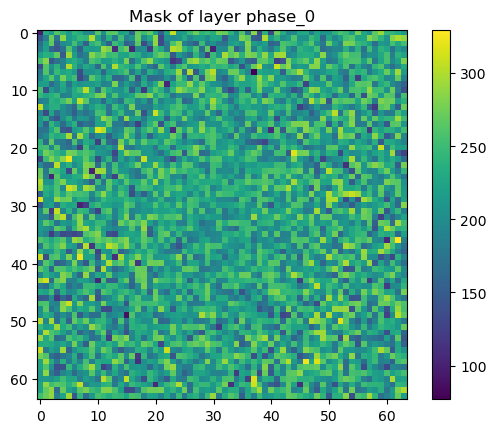

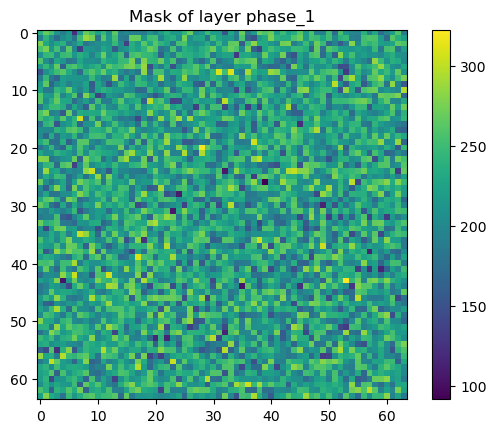

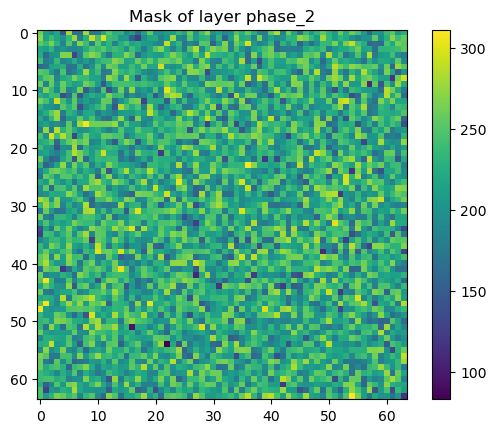

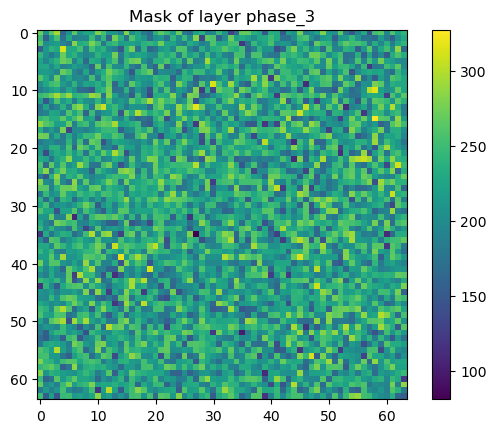

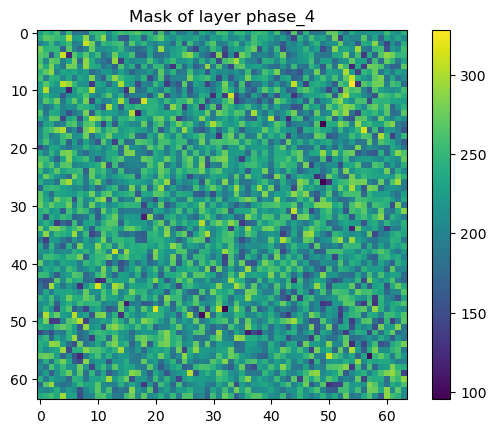

In [187]:
mask_visualiztion()

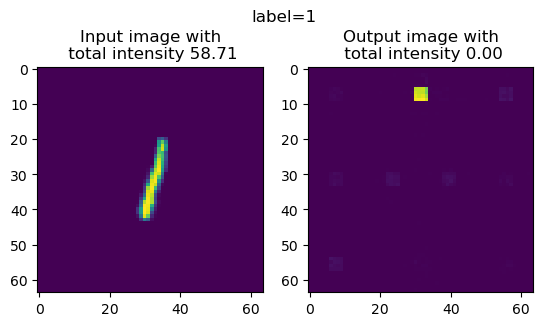

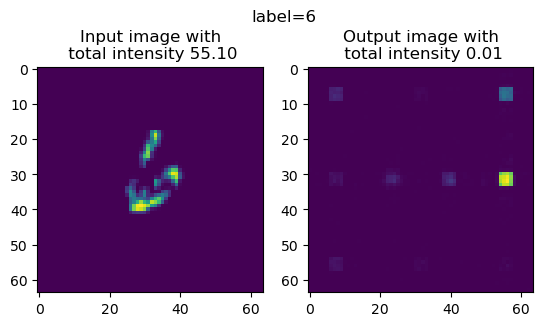

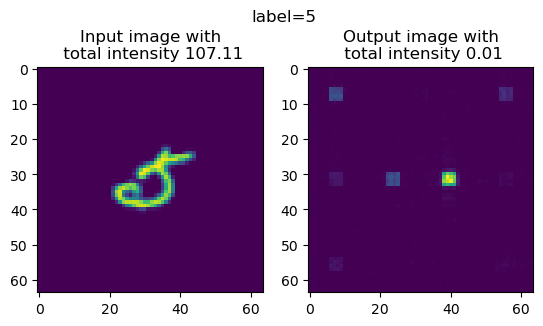

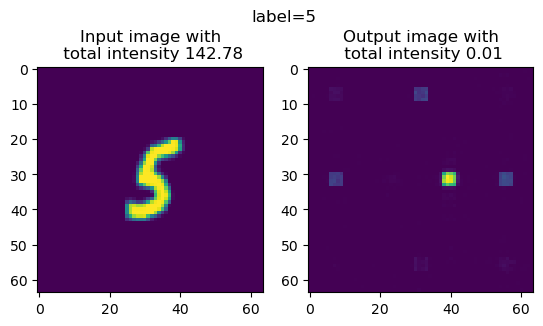

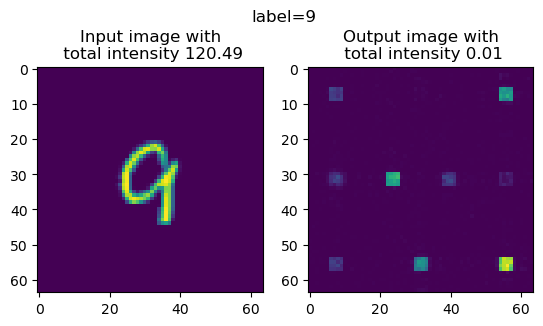

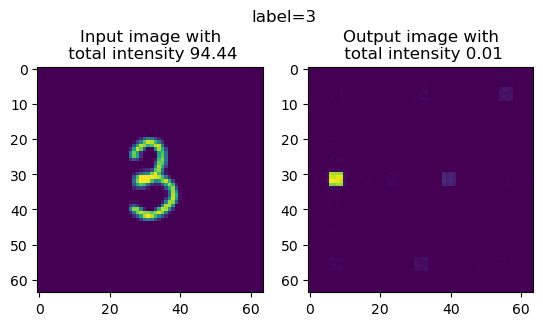

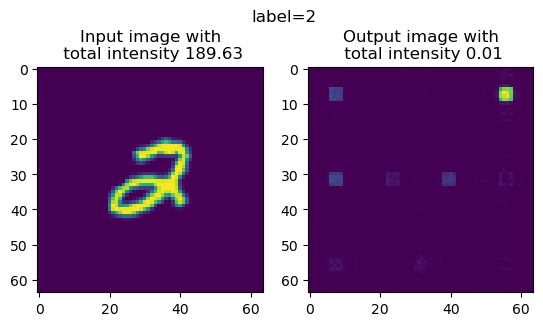

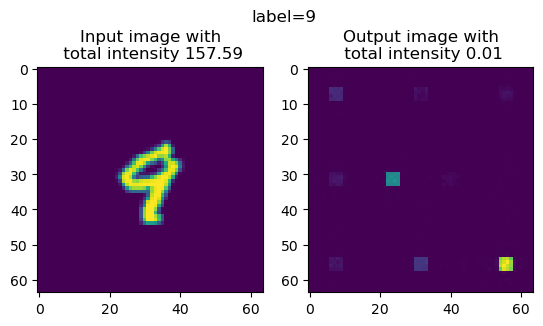

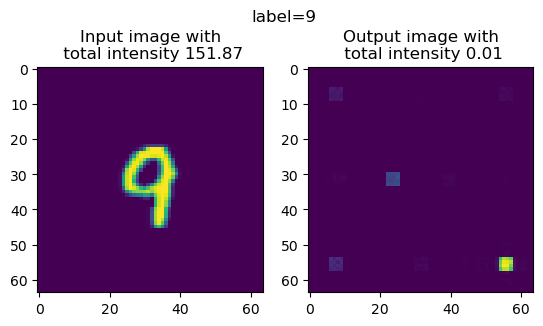

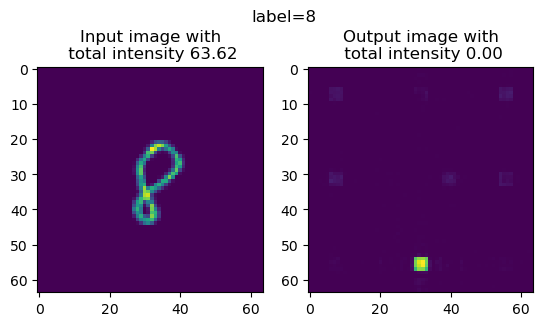

In [222]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
    visualize(val_dataset[ind][0], val_dataset[ind][1])

In [189]:
def confusion_matrix(predicted, labels, conf_matrix):
    for p, t in zip(predicted, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
#首先定义一个 分类数*分类数 的空混淆矩阵
conf_matrix = torch.zeros(classes_num, classes_num)
# 使用torch.no_grad()可以显著降低测试用例的GPU占用
with torch.no_grad(): # 停止梯度更新
    for i, (images, labels) in enumerate(val_dataloader):
        images = images.to(device)
        images = torch.sqrt(torch.squeeze(images))
        labels = labels.to(device)

        out_labels, out_images = model(images)
        _, predicted = torch.max(out_labels.data, 1)
        
        #记录混淆矩阵参数
        conf_matrix = confusion_matrix(predicted, labels, conf_matrix)
        conf_matrix = conf_matrix.cpu()

In [190]:
conf_matrix = np.array(conf_matrix)# 将混淆矩阵从gpu转到cpu再转到np
corrects = conf_matrix.diagonal(offset = 0)#抽取对角线的每种分类的识别正确个数
per_classes = conf_matrix.sum(axis = 1)#抽取每个分类数据总的测试条数

print("混淆矩阵总元素个数：{},测试集总个数:{}".format(int(np.sum(conf_matrix)), BATCH_SIZE*len(val_dataloader)))
np.set_printoptions(suppress=True) 
print(conf_matrix)

# 获取每种label的识别准确率
percent = [rate*100 for rate in corrects/per_classes]
per_classes = list(per_classes)
corrects = list(corrects)

print("每种标签总个数：{}".format('  '.join(['{:.0f}'.format(i) for i in per_classes])))
print("每种标签预测正确的个数：{}".format('  '.join(['{:.0f}'.format(i) for i in corrects])))
print("每种标签的识别准确率为：{}".format('%  '.join(['{:.1f}'.format(i) for i in percent])), end='%')

混淆矩阵总元素个数：10000,测试集总个数:10000
[[ 961.    0.   18.   12.    1.   15.   33.    5.   27.   28.]
 [   0. 1095.    1.    3.    2.    2.    2.   16.    9.    7.]
 [   0.    3.  909.   27.    8.    7.    3.   26.   16.    6.]
 [   2.    3.   12.  880.    0.   36.    0.    6.   32.   14.]
 [   0.    1.   14.    1.  900.    5.    5.   13.   17.   49.]
 [   3.    1.    3.   21.    0.  763.   16.    2.   20.    8.]
 [   7.    9.   21.   12.   15.   25.  897.    5.   19.    1.]
 [   1.    2.   22.   32.    1.   14.    0.  922.   19.   39.]
 [   6.   21.   31.   16.   12.   18.    2.    2.  804.    8.]
 [   0.    0.    1.    6.   43.    7.    0.   31.   11.  849.]]
每种标签总个数：1100  1137  1005  985  1005  837  1011  1052  920  948
每种标签预测正确的个数：961  1095  909  880  900  763  897  922  804  849
每种标签的识别准确率为：87.4%  96.3%  90.4%  89.3%  89.6%  91.2%  88.7%  87.6%  87.4%  89.6%

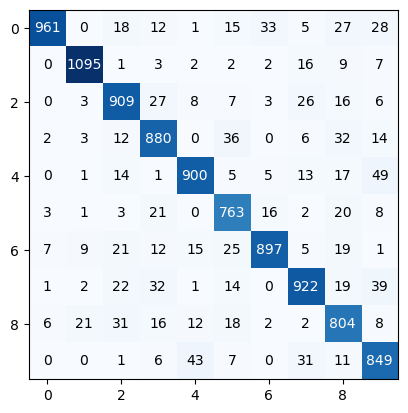

In [191]:
# 绘制混淆矩阵
label_ticks = list()
for i in range(classes_num):
    label_ticks = label_ticks + ['{}'.format(classes[i])]

# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
thresh = conf_matrix.max() / 2	#数值颜色阈值，如果数值超过这个，就颜色加深。
for i in range(classes_num):
    for j in range(classes_num):
        info = int(conf_matrix[j, i])
        plt.text(i, j, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
plt.show()

In [192]:
# 将模型中的phase导出来
phase = []
for param in model.named_parameters():
    phase.append(param[1])

In [193]:
phase[0].shape

torch.Size([64, 64])

In [194]:
# 写一个测试模型，用于查看中间层的输出图案
class DNN_test(torch.nn.Module):
    def __init__(self, phase=[], Amp = [], num_layers=5, wl = 532e-9, N_pixels = 64, pixel_size = 10*wl, 
                 distance = []):

        super(DNN_test, self).__init__()
        
        # 定义中间的衍射层
        self.diffractive_layers = torch.nn.ModuleList([Diffractive_Layer(wl, N_pixels, pixel_size, distance[i])
                                                       for i in range(num_layers)])
        # 定义最后的探测层
        self.last_diffractive_layer = Propagation_Layer(wl, N_pixels, pixel_size, distance[-1])
        self.sofmax = torch.nn.Softmax(dim=-1)
    
    # 计算多层衍射前向传播
    def forward(self, E):
        E_out = []
        Int = []
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(E)
            # 这里相当于加了一层sigmoid非线性激活，将相位控制在0到2pi
#             constr_phase = 2*torch.pi*torch.sigmoid(self.phase[index])
            constr_phase = 2*torch.pi*phase[index]
            exp_j_phase = torch.exp(1j*constr_phase) #torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            E = temp * exp_j_phase * torch.sigmoid(Amp[index])
            E_out.append(E)
        E_out.append(self.last_diffractive_layer(E_out[-1]))
        for i in range(len(E_out)):
            Int.append(torch.abs(E_out[i])**2)
        return Int

In [195]:
model_test = DNN_test(phase = phase, Amp = Amp, num_layers = 5, wl = wl, pixel_size = pixel_size, distance = distance).to(device)

In [196]:
mid_img = model_test(images_E)

In [197]:
images_E.shape

torch.Size([200, 64, 64])

In [198]:
len(mid_img[0])

200

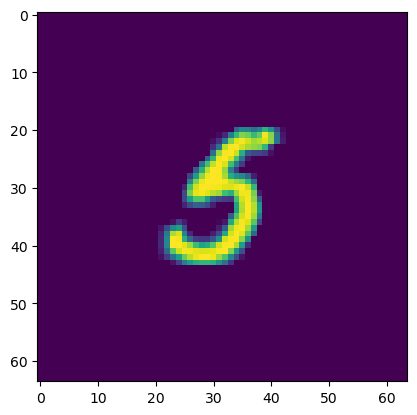

In [213]:
# Batch里第2个样品的原图
plt.imshow(images_E[1].cpu().detach().numpy())

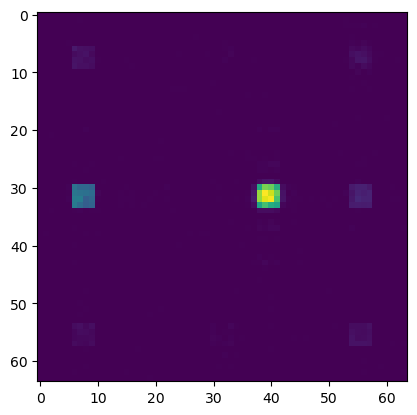

In [221]:
# Batch里第2个样品在第1层的图案
plt.imshow(mid_img[5][1].cpu().detach().numpy())